# Рекурентные сетки для временных рядов

## 1. Какими бывают ячейки

Любая рекурентная ячейка может отдавать на выход либо полную последовательность либо только последний свой член. За это отвечает аргумент  `return_sequence`.

- `SimpleRNN` - обычная RNN ячейка без изысков.
- `LSTM` - LSTM ячейка
- `GRU` - GRU ячейка

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf 
tf.__version__

'2.8.0'

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional, BatchNormalization

model = Sequential()
model.add(Embedding(1, 1))
model.add(SimpleRNN(5))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 1)           1         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5)                 35        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [9]:
model = Sequential()
model.add(Embedding(1, 1))
model.add(SimpleRNN(2, return_sequences=True))
model.add(SimpleRNN(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 1)           1         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 2)           8         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


Рекурентные ячейки, как и обычные полносвязные, можно выстраивать в слои друг за другом. 

In [10]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(1))  # Последний выход должен выводить только последний результат
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 1)                 34        
                                                                 
Total params: 326,274
Trainable params: 326,274
Non-trainable params: 0
_________________________________________________________________


Можно сделать модель двунаправленной.

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(1, activation='relu'), input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 2)                24        
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [6]:
# LSTM()

In [7]:
# GRU()

# Авиаперевозки

In [14]:
# !pip install sktime

In [15]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [16]:
type(y)

pandas.core.series.Series

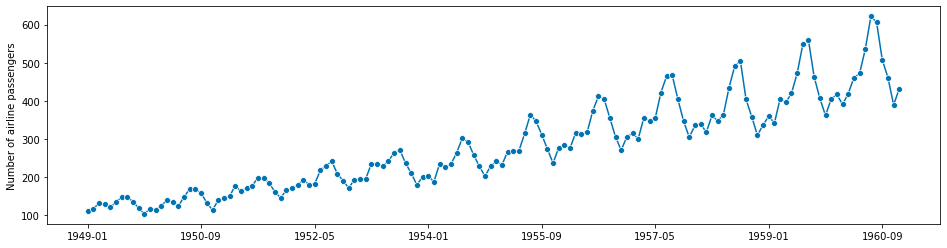

In [17]:
plot_series(y);

120 24


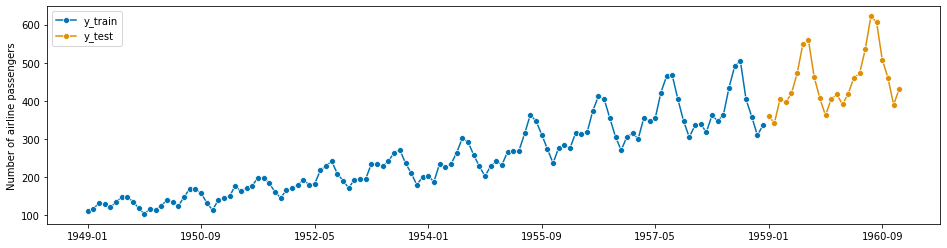

In [18]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=24)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [19]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

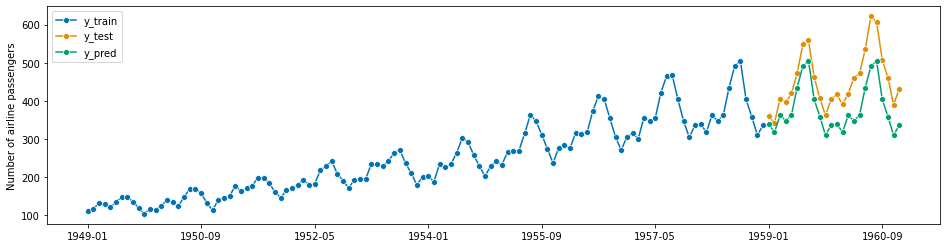

In [20]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [21]:
from sklearn.metrics import mean_absolute_error as mae

def mape(y_pred, y_test):
    return 100*np.mean(np.abs((y_pred - y_test)/y_test))
    
mape(y_pred, y_test.values) 

15.523355162420376

In [25]:
# !pip install pmdarima

In [26]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(sp=12, d=0, max_p=3, max_q=3, 
                       information_criterion='bic',
                       suppress_warnings=True)

forecaster.fit(y_train)

AutoARIMA(d=0, information_criterion='bic', max_p=3, max_q=3, sp=12,
          suppress_warnings=True)

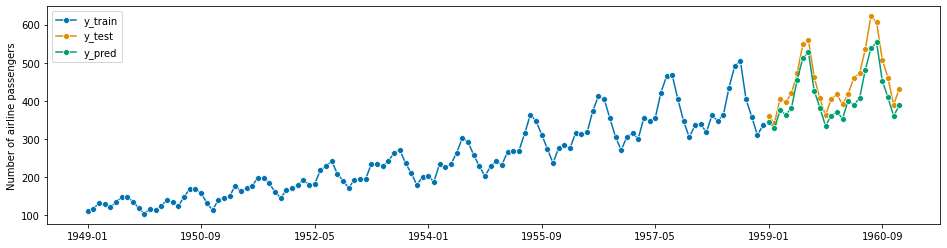

In [27]:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [28]:
mape(y_pred, y_test.values)

8.60119039151878

In [31]:
# !pip install tbats

In [32]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=True,
    n_jobs=-1
)

forecaster.fit(y_train)

TBATS(n_jobs=-1, sp=12, use_box_cox=True, use_damped_trend=False,
      use_trend=True)

In [35]:
y_pred = forecaster.predict(fh)

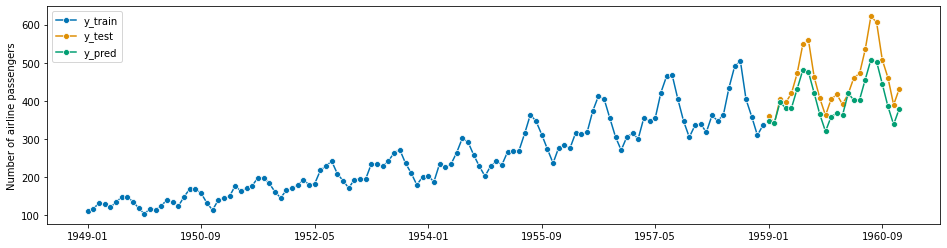

In [37]:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [36]:
mape(y_pred, y_test.values)

10.323493389595283

# LSTM 

In [40]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [41]:
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# насколько сильно заглядывать в прошлое
n_steps = 5

# разбиение
X1, y1 = split_sequence(raw_seq, n_steps)
y1

array([60, 70, 80, 90])

In [42]:
X1

array([[10, 20, 30, 40, 50],
       [20, 30, 40, 50, 60],
       [30, 40, 50, 60, 70],
       [40, 50, 60, 70, 80]])

In [43]:
y_values = y.values
n_steps = 12

treshhold = -24 # последние 2 года в тест
X, Y = split_sequence(y_values, n_steps)

y_train, X_train = Y[:treshhold], X[:treshhold]
y_test, X_test = Y[treshhold:], X[treshhold:]

In [44]:
X_train.shape

(108, 12)

In [45]:
# [samples, timesteps] => [samples, timesteps, features]

n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train.shape

(108, 12, 1)

In [46]:
model = Sequential()
model.add(BatchNormalization())

model.add(GRU(10, activation='relu', return_sequences=True,
               input_shape=(n_steps, n_features)))

model.add(GRU(10, activation='relu', ))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [47]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, shuffle=False, verbose=0)

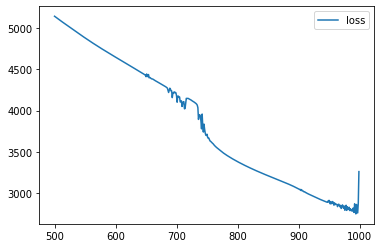

In [48]:
pd.DataFrame(history.history)[500:].plot();

In [49]:
y_pred = model.predict(X_test).T[0]
y_pred

array([226.72351, 219.0931 , 186.97963, 234.90851, 255.77667, 417.22113,
       408.4256 , 317.22192, 216.97627, 219.12865, 229.35345, 215.08357,
       163.41487, 164.08186, 192.32181, 250.84766, 301.81497, 255.04501,
       359.4449 , 384.20706, 279.19293, 287.40424, 250.81616, 164.72144],
      dtype=float32)

In [50]:
mape(y_pred, y_test) # надо учить модель дальше!

43.15953138362447

## Почиташки: 

* [Большой гайд с разными рекурентными сетками](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [Его продолжение на данных про авиаперевозки](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) 
* [Код с потреблением электроенергии](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)  